## Set Up

### Activate vritual environment

### Import libraries and set up API

In [73]:
pip install Bio
pip install bs4
pip install lxml

SyntaxError: invalid syntax (4163670414.py, line 1)

In [ ]:
from Bio import Entrez
from Bio import Medline
import time
import pandas as pd

## PMC Dataset

### Search PubMed & PMC Open Access using eSearch
eSearch: Searches and retrieves primary IDs (for use in EFetch, ELink, and ESummary) and term translations and optionally retains results for future use in the user’s environment.
eFetch: extracts journal information based on ID list
For information, go to https://biopython.org/docs/1.75/api/Bio.Entrez.html or https://www.ncbi.nlm.nih.gov/books/NBK25499/#chapter4.EFetch or https://pubmed.ncbi.nlm.nih.gov/help/#search-field-descriptions-and-tags

choose your database: pubmed or pmc open access
pmc open access database contains journal articles that are made available under license terms that allow reuse. https://pmc.ncbi.nlm.nih.gov/tools/openftlist/ 
pmc open access search guide can be found here: https://pmc.ncbi.nlm.nih.gov/about/userguide/#searchfields

- must include this in methodology part of book writing

In [ ]:
#search PubMed

import os
from dotenv import load_dotenv

load_dotenv() # This looks for the .env file and loads it

# connect to PubMed
Entrez.email = os.getenv('ENTREZ_EMAIL')

#define search terms - for PubMed
search_term = 'pancreatic cancer[ti] AND pancreatic cancer[ab] AND ' \
'(symptom[tiab] OR symptoms[tiab] "clinical presentation"[tiab] OR signs[tiab] OR manifestations[tiab] OR "signs and symptoms"[mh]) AND free full text[sb]'

handle = Entrez.esearch(db="pubmed", term=search_term, retmax=2000) 
record = Entrez.read(handle)
handle.close()

# Get list of PubMed IDs from search results
pubmed_id_list = record["IdList"]
print(f" {len(pubmed_id_list)} PubMed articles found")

 646 PubMed articles found


In [ ]:
#search PMC Open Access

#define search terms 
Entrez.email = os.getenv('ENTREZ_EMAIL')

search_term_2 = (
    'pancreatic cancer[ab] AND pancreatic cancer[ti] AND '
    '(symptom[ab] OR symptoms[ab] OR "clinical presentation"[AB] OR signs[AB] OR manifestations[AB]) '
    'AND open access[filter]')

handle = Entrez.esearch(db="pmc", term=search_term_2, retmax=2000) 
record = Entrez.read(handle)
handle.close()

# Get list of PubMed IDs from search results
pmc_id_list = record["IdList"]
print(f" {len(pmc_id_list)} PMC Open Access articles found")

 407 PMC Open Access articles found


### Match PMC ID to PubMed ID to get detailed article metadata and abstract (Medline format) into csv file
Link PMCID to PMID to download and write all relevant information / PubMed data elements about each citation into a csv file 
The element descriptions and options can be found here: https://www.nlm.nih.gov/bsd/licensee/data_elements_doc.html

In [ ]:
# for PMC Open Access, you have to link PMCIDs to PMIDs to download metadata
pmids = []

# PMC LinkOut: get related PMIDs for each PMCID
for pmcid in pmc_id_list:  # Limit to first 53 for demo
    handle = Entrez.elink(dbfrom="pmc", db="pubmed", id=pmcid)
    linkset = Entrez.read(handle)
    handle.close()

    for link in linkset[0]["LinkSetDb"]:
        if link["LinkName"] == "pmc_pubmed":
            for link_item in link["Link"]:
                pmids.append(link_item["Id"])

print(f"Mapped PMCIDs to PMIDs: {pmids[:5]}")

Mapped PMCIDs to PMIDs: ['40568369', '40520838', '40507369', '40471466', '40418805']


In [ ]:
#Get PubMed metadata and abstracts(Medline)

# Initialize list to store parsed records
records = []

# Batch size for PubMed efetch (max 10,000 per NCBI)
batch_size = 100

# Loop through id_list in chunks
for start in range(0, len(pmids), batch_size):
    end = min(start + batch_size, len(pmids))
    batch_ids = pmids[start:end]

    try:
        # Fetch records from PubMed using Medline format
        handle = Entrez.efetch(
            db="pubmed",
            id=batch_ids,
            rettype="medline",
            retmode="text"
        )

        # Parse the plain-text MEDLINE into structured dicts
        batch_data = Medline.parse(handle)
        
        # Append each parsed record to the records list
        records.extend(batch_data)

        handle.close()

        print(f"✅ Fetched records {start + 1} to {end}")

        # NCBI rate limit: 3 requests/sec without API key
        time.sleep(0.4)

    except Exception as e:
        print(f"⚠️ Error fetching records {start + 1} to {end}: {e}")
        continue

✅ Fetched records 1 to 100
✅ Fetched records 101 to 200
✅ Fetched records 201 to 300
✅ Fetched records 301 to 400
✅ Fetched records 401 to 405


In [ ]:
# Flatten and normalize the records
from pathlib import Path
working_dir = Path.cwd()

df = pd.json_normalize(records)

data_path = working_dir/data/"raw_pubmed_records.csv"

# Save to CSV
df.to_csv(data_path, index=False, encoding='utf-8')


In [ ]:
import csv

# Define the CSV file name
output_csv = "/data/pubmed_medline_records.csv"

# Define fields you want to extract and map them to readable names
csv_fields = [
    ("PMID", "PMID"),
    ("TI", "Title"),
    ("AB", "Abstract"),
    ("MH", "MeSH headings"),
    ("AU", "Authors"),
    ("JT", "Journal"),
    ("DP", "Year"),
    ("DP", "Month"),
    ("SO", "Source"),
    ("PL", "Country")
]

# Open CSV for writing
with open(output_csv, mode="w", encoding="utf-8", newline="") as file:
    writer = csv.DictWriter(file, fieldnames=[field[1] for field in csv_fields])
    writer.writeheader()

    for record in records:
        row = {}
        for medline_key, csv_key in csv_fields:
            value = record.get(medline_key, "")

            # Join lists into a semicolon-separated string
            if isinstance(value, list):
                value = "; ".join(value)

            if medline_key == "DP":
                parts = value.split(" ")
                if csv_key == "Year":
                    value = parts[0] if len(parts) > 0 else ""
                elif csv_key == "Month":
                    value = parts[1] if len(parts) > 1 else ""

            row[csv_key] = value

        writer.writerow(row)

print(f"✅ Saved {len(records)} records to {output_csv}")


In [ ]:
records

[{'PMID': '40471466',
  'OWN': 'NLM',
  'STAT': 'MEDLINE',
  'DCOM': '20250605',
  'LR': '20250608',
  'IS': '1941-6636 (Electronic) 1941-6628 (Print)',
  'VI': '56',
  'IP': '1',
  'DP': '2025 Jun 5',
  'TI': 'Pancreatic Cancer Risk Assessment Tools in Primary Care: A Mixed Methods Systematic Review.',
  'PG': '128',
  'LID': '10.1007/s12029-025-01229-5 [doi] 128',
  'AB': "BACKGROUND: Pancreatic cancer is the twelfth most common cancer worldwide, but high mortality rates make it the sixth leading cause of cancer deaths. Diagnosis is frequently too late for curative intervention. Risk assessment tools incorporating diagnostic prediction models may assist early pancreatic cancer detection by primary care clinicians. AIM AND METHODS: This mixed methods systematic review aims to identify risk assessment tools which can be used for the detection of pancreatic cancer and have been investigated in primary care. It also seeks to synthesise the qualitative and quantitative evidence relating t

### Extract PMC Open Access articles and full-text(XML format)

In [ ]:
#Extrating full texts
import time
import os

# Create output folder
os.makedirs("/data/pmc_xml", exist_ok=True)

batch_size = 10  # smaller batch because files are big

for start in range(0, len(pmc_id_list), batch_size):
    end = min(start + batch_size, len(pmc_id_list))
    batch_ids = pmc_id_list[start:end]

    try:
        handle = Entrez.efetch(
            db="pmc",
            id=batch_ids,
            rettype="full",   # or "xml"
            retmode="xml"
        )

        xml_data = handle.read()
        xml_data_str = xml_data.decode('utf-8')
        handle.close()
    

        # Save each batch or each ID
        with open(f"/data/pmc_xml/pmc_{start+1}_{end}.xml", "w", encoding="utf-8") as f:
            f.write(xml_data_str)

        print(f"✅ Downloaded PMC full-text {start+1}–{end}")

        time.sleep(0.5)

    except Exception as e:
        print(f"⚠️ Error fetching PMCIDs {start+1}–{end}: {e}")


✅ Downloaded PMC full-text 1–10
✅ Downloaded PMC full-text 11–20
✅ Downloaded PMC full-text 21–30
✅ Downloaded PMC full-text 31–40
✅ Downloaded PMC full-text 41–50
✅ Downloaded PMC full-text 51–60
✅ Downloaded PMC full-text 61–70
✅ Downloaded PMC full-text 71–80
✅ Downloaded PMC full-text 81–90
✅ Downloaded PMC full-text 91–100
✅ Downloaded PMC full-text 101–110
✅ Downloaded PMC full-text 111–120
✅ Downloaded PMC full-text 121–130
✅ Downloaded PMC full-text 131–140
✅ Downloaded PMC full-text 141–150
✅ Downloaded PMC full-text 151–160
✅ Downloaded PMC full-text 161–170
✅ Downloaded PMC full-text 171–180
✅ Downloaded PMC full-text 181–190
✅ Downloaded PMC full-text 191–200
✅ Downloaded PMC full-text 201–210
✅ Downloaded PMC full-text 211–220
✅ Downloaded PMC full-text 221–230
✅ Downloaded PMC full-text 231–240
✅ Downloaded PMC full-text 241–250
✅ Downloaded PMC full-text 251–260
✅ Downloaded PMC full-text 261–270
✅ Downloaded PMC full-text 271–280
✅ Downloaded PMC full-text 281–290
✅ Dow

In [ ]:
#Split the batches to save as individual xml_files
import time
import glob
from bs4 import BeautifulSoup

input_dir = '/data/pmc_xml'
output_dir = '/data/pmc_xml_files'
os.makedirs(output_dir, exist_ok=True)

batch_files = glob.glob(os.path.join(input_dir, "*.xml"))

for file in batch_files:
    with open(file, 'r', encoding='utf-8') as f:
        content = f.read()

    soup = BeautifulSoup(content, 'lxml-xml')

    # Make sure we are inside the right root
    articleset = soup.find('pmc-articleset')
    if not articleset:
        print(f"⚠️ No <pmc-articleset> found in {file}")
        continue

    articles = articleset.find_all('article')
    print(f"📄 {file}: Found {len(articles)} articles")

    for i, article in enumerate(articles):
        pmcid_tag = article.find('article-id', {'pub-id-type': 'pmcid'})
        pmcid = pmcid_tag.text.strip() if pmcid_tag else f"{os.path.basename(file)}_article{i+1}"

        output_path = os.path.join(output_dir, f"{pmcid}.xml")
        with open(output_path, 'w', encoding='utf-8') as out_f:
            out_f.write(str(article))

print(f"\n✅ Splitting complete. All articles saved to {output_dir}")


In [ ]:
#Count number of xml files
xml_files = [f for f in os.listdir(output_dir) if f.endswith('.xml')]

print(f"Number of JSON files: {len(xml_files)}")

Number of JSON files: 407


### Extract article body

In [ ]:
import os
import glob
import json
from bs4 import BeautifulSoup

input_dir = "/data/pmc_xml_files/"
output_dir = "/data/pmc_extracted_text"
os.makedirs(output_dir, exist_ok=True)


for xml_file in glob.glob(os.path.join(input_dir, "*.xml")):
    with open(xml_file, encoding="utf-8") as f:
        xml_content = f.read()

    soup = BeautifulSoup(xml_content, "xml")

    # Get PMC ID from XML <article-id pub-id-type="pmcid"> or filename
    pmcid_tag = soup.find("article-id", {"pub-id-type": "pmcid"})
    if pmcid_tag:
        pmcid = pmcid_tag.get_text(strip=True)
    else:
        pmcid = os.path.splitext(os.path.basename(xml_file))[0]  # fallback to filename

    # Remove section titles and other non-body tags
    for tag in soup.find_all(["title", "fig", "table-wrap", "ref-list", "supplementary-material"]):
        tag.decompose()

    # Extract all paragraph text
    paragraphs = soup.find_all("p")
    full_text = "\n\n".join(p.get_text(strip=True) for p in paragraphs)

    # Save to JSON
    output_path = os.path.join(output_dir, f"{pmcid}.json")
    with open(output_path, "w", encoding="utf-8") as out_f:
        json.dump({"pmcid": pmcid, "text": full_text}, out_f, ensure_ascii=False, indent=2)


In [ ]:
#read extracted json texts (example: PMC1751121.json)
import json
with open('/data/pmc_extracted_text/PMC1751121.json', "r", encoding="utf-8") as f:
    data = json.load(f)

# Print preview
print("PMC ID:", data["pmcid"])
print(data["text"][:500])

PMC ID: PMC1751121
Pancreatic cancer is a deadly disease. Discovery of the mutated genes that cause the inherited form(s) of the disease may shed light on the mechanism(s) of oncogenesis. Previously we isolated a susceptibility locus for familial pancreatic cancer to chromosome location 4q32–34. In this study, our goal was to discover the identity of the familial pancreatic cancer gene on 4q32 and determine the function of that gene.

A customized microarray of the candidate chromosomal region affecting pancreatic


### Extract conclusion and abstract

In [ ]:
from pathlib import Path
from bs4 import BeautifulSoup
import json
import os

# Directory containing your saved XML files
xml_dir = Path("/data/pmc_xml")
output_file = Path("/data/pmc_abstract_conclusion.json")

# Ensure output directory exists
output_file.parent.mkdir(parents=True, exist_ok=True)

# Keywords for matching conclusion sections
conclusion_headings = {"conclusion", "conclusions", "5. conclusions"}

# Extract Abstract and Conclusions from each XML file
articles_data = []

for xml_file in xml_dir.glob("*.xml"):
    with open(xml_file, encoding="utf-8") as f:
        soup = BeautifulSoup(f, "lxml")

    for article in soup.find_all("article"):
        article_data = {"pmcid": None, "abstract": "", "conclusion": ""}

        # Extract PMCID
        pmcid_tag = article.find("article-id", {"pub-id-type": "pmc"})
        if pmcid_tag:
            article_data["pmcid"] = pmcid_tag.get_text(strip=True)

        # Extract Abstract
        abstract = article.find("abstract")
        if abstract:
            article_data["abstract"] = abstract.get_text(separator=" ", strip=True)

        # Extract Conclusion-like sections
        conclusion_text = ""
        for sec in article.find_all("sec"):
            title_tag = sec.find("title")
            if title_tag:
                section_title = title_tag.get_text(strip=True).lower()
                if section_title in conclusion_headings:
                    conclusion_text += " " + sec.get_text(separator=" ", strip=True)

        article_data["conclusion"] = conclusion_text.strip()

        if article_data["abstract"] or article_data["conclusion"]:
            articles_data.append(article_data)

# Save to JSON
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(articles_data, f, ensure_ascii=False, indent=2)

print(f"✅ Saved {len(articles_data)} records to {output_file}")


In [ ]:
import os
import glob
import json
from bs4 import BeautifulSoup

input_dir = "/data/pmc_xml_files/"
output_dir = "/data/pmc_abstract_conclusion_text"
os.makedirs(output_dir, exist_ok=True)

# Define acceptable headings for conclusions
conclusion_headings = {"conclusion", "conclusions", "5. conclusions"}

for xml_file in glob.glob(os.path.join(input_dir, "*.xml")):
    with open(xml_file, encoding="utf-8") as f:
        soup = BeautifulSoup(f.read(), "xml")

    # Get PMCID
    pmcid_tag = soup.find("article-id", {"pub-id-type": "pmcid"})
    pmcid = pmcid_tag.get_text(strip=True) if pmcid_tag else os.path.splitext(os.path.basename(xml_file))[0]

    # ===== EXTRACT ABSTRACT =====
    abstract_texts = []
    abstract_tags = soup.find_all("abstract", recursive=True)
    for abstract_tag in abstract_tags:
        # Some abstracts have nested <sec><title> and <p> inside
        for p in abstract_tag.find_all("p"):
            abstract_texts.append(p.get_text(strip=True))

    # ===== EXTRACT CONCLUSION(S) =====
    conclusion_texts = []
    for sec in soup.find_all("sec"):
        title_tag = sec.find("title")
        if title_tag and title_tag.get_text(strip=True).lower() in conclusion_headings:
            for p in sec.find_all("p"):
                conclusion_texts.append(p.get_text(strip=True))

    # Skip if either abstract or conclusion is missing
    if not abstract_texts or not conclusion_texts:
        continue

    combined_text = "\n\n".join(abstract_texts + conclusion_texts)

    # Save to JSON
    output_path = os.path.join(output_dir, f"{pmcid}.json")
    with open(output_path, "w", encoding="utf-8") as out_f:
        json.dump({"pmcid": pmcid, "text": combined_text}, out_f, ensure_ascii=False, indent=2)

print("✅ Finished extracting abstracts and conclusions.")


✅ Finished extracting abstracts and conclusions.


## Push files to HuggingFace

In [88]:

# Install the Hugging Face CLI
!pip install -U "huggingface_hub[cli]"

     -------------------------------------- 558.8/558.8 kB 5.8 MB/s eta 0:00:00
     ---------------------------------------- 67.7/67.7 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.33.0
    Uninstalling huggingface-hub-0.33.0:
      Successfully uninstalled huggingface-hub-0.33.0



[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [90]:
# Login with your Hugging Face credentials
!pip install -U huggingface_hub


[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from huggingface_hub import login, notebook_login
import os
from dotenv import load_dotenv

load_dotenv() 

login(token= os.getenv('HUGGINGFACE_TOKEN'))

In [ ]:
from huggingface_hub import HfApi
api = HfApi()

# Upload all the content from the local folder to hf remote Space.
api.upload_folder(
    folder_path="/data/pmc_extracted_text",
    repo_id=os.getenv("HF_REPO_ID"),
    repo_type="dataset",
)

It seems you are trying to upload a large folder at once. This might take some time and then fail if the folder is too large. For such cases, it is recommended to upload in smaller batches or to use `HfApi().upload_large_folder(...)`/`hf upload-large-folder` instead. For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/upload#upload-a-large-folder.


CommitInfo(commit_url='https://huggingface.co/datasets/Fool-of-a-Took/pmc_pc_articles/commit/9edeffc91340f426d2def814c4d03518783954f7', commit_message='Upload folder using huggingface_hub', commit_description='', oid='9edeffc91340f426d2def814c4d03518783954f7', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/Fool-of-a-Took/pmc_pc_articles', endpoint='https://huggingface.co', repo_type='dataset', repo_id='Fool-of-a-Took/pmc_pc_articles'), pr_revision=None, pr_num=None)

In [ ]:
#Upload article metadata to hf
from huggingface_hub import HfApi
api = HfApi()
api.upload_file(
    path_or_fileobj="/data/pubmed_medline_records.csv",
    path_in_repo="article-metadata-medline.csv",
    repo_id=os.getenv("HF_REPO_ID"),
    repo_type="dataset",
)

CommitInfo(commit_url='https://huggingface.co/datasets/Fool-of-a-Took/pmc_pc_articles/commit/9b963d4c7a51c6e5b09148df8161737758fed309', commit_message='Upload article-metadata-medline.csv with huggingface_hub', commit_description='', oid='9b963d4c7a51c6e5b09148df8161737758fed309', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/Fool-of-a-Took/pmc_pc_articles', endpoint='https://huggingface.co', repo_type='dataset', repo_id='Fool-of-a-Took/pmc_pc_articles'), pr_revision=None, pr_num=None)

#### Upload abstract & conclusion

In [ ]:
from huggingface_hub import HfApi
api = HfApi()

# Upload all the content from the local folder to hf remote Space.
api.upload_folder(
    folder_path="/data/pmc_abstract_conclusion_text",
    repo_id=os.getenv(f"HF_REPO_ID" + "pc_pmc_abstract_conclusion"),
    repo_type="dataset",
)

c:\Users\chery\dl-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
It seems you are trying to upload a large folder at once. This might take some time and then fail if the folder is too large. For such cases, it is recommended to upload in smaller batches or to use `HfApi().upload_large_folder(...)`/`hf upload-large-folder` instead. For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/upload#upload-a-large-folder.


CommitInfo(commit_url='https://huggingface.co/datasets/Fool-of-a-Took/pc_pmc_abstract_conclusion/commit/e6466469497617e69109332cf46c9b6135d4daa2', commit_message='Upload folder using huggingface_hub', commit_description='', oid='e6466469497617e69109332cf46c9b6135d4daa2', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/Fool-of-a-Took/pc_pmc_abstract_conclusion', endpoint='https://huggingface.co', repo_type='dataset', repo_id='Fool-of-a-Took/pc_pmc_abstract_conclusion'), pr_revision=None, pr_num=None)

In [ ]:
#Upload article metadata to hf
from huggingface_hub import HfApi
api = HfApi()
api.upload_file(
    path_or_fileobj="/data/pubmed_medline_records.csv",
    path_in_repo="article-metadata-medline.csv",
    repo_id=os.getenv(f"HF_REPO_ID" + "pc_pmc_abstract_conclusion"),
    repo_type="dataset",
)

CommitInfo(commit_url='https://huggingface.co/datasets/Fool-of-a-Took/pc_pmc_abstract_conclusion/commit/5928e79c596e814d7f80694455d704989e8749f0', commit_message='Upload article-metadata-medline.csv with huggingface_hub', commit_description='', oid='5928e79c596e814d7f80694455d704989e8749f0', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/Fool-of-a-Took/pc_pmc_abstract_conclusion', endpoint='https://huggingface.co', repo_type='dataset', repo_id='Fool-of-a-Took/pc_pmc_abstract_conclusion'), pr_revision=None, pr_num=None)

## EDA of PMC articles

### MeSH Headings

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import csv
import seaborn as sns
import wordcloud
from wordcloud import WordCloud, STOPWORDS

In [ ]:
#use matched PubMed MeSH headings to get article focus

records = pd.read_csv('/data/pubmed_medline_records.csv')
records = records.dropna(subset = ["MeSH headings"]) #drop records with missing MeSH headings
records

PMID                                              Title  \
0    40568369  Advanced Detection of Pancreatic Cancer Circul...   
3    40471466  Pancreatic Cancer Risk Assessment Tools in Pri...   
5    40392528  Anatomically resectable versus biologically bo...   
6    40430018  Identification of Cancer Associated Fibroblast...   
8    40376004  Case Report: Combined PD-1 and tyrosine kinase...   
..        ...                                                ...   
400  17194196  Palladin mutation causes familial pancreatic c...   
401  17066513  [6]-Gingerol induces cell cycle arrest and cel...   
402  10907780  Pancreatic adenocarcinoma presenting as sinist...   
403   8554969  Phase II study of gemcitabine in patients with...   
404   3154606  A study of 122 cases of pancreatic cancer diag...   

                                              Abstract  \
0    Background: Pancreatic ductal adenocarcinoma (...   
3    BACKGROUND: Pancreatic cancer is the twelfth m...   
5    BACKGROUND: The anatomically resectable pancre...   
6    Pancreatic cancer (PC) is highly aggressive, w...   
8    Pancreatic cancer is characterized by a poor p...   
..                                                 ...   
400  BACKGROUND: Pancreatic cancer is a deadly dise...   
401  [6]-Gingerol, a major phenolic compound derive...   
402  A rare syndrome, sinistral (left-sided) portal...   
403  The efficacy and safety of gemcitabine at a st...   
404  ERCP is a highly accurate and specific method ...   

                                         MeSH headings  \
0    *Neoplastic Cells, Circulating/pathology/metab...   
3    Humans; *Pancreatic Neoplasms/diagnosis; Prima...   
5    Humans; *Pancreatic Neoplasms/pathology/surger...   
6    Humans; *Pancreatic Neoplasms/genetics/patholo...   
8    Male; *Antineoplastic Combined Chemotherapy Pr...   
..                                                 ...   
400  Actinin/genetics; Adenocarcinoma/*genetics; Bl...   
401  Antineoplastic Agents/*pharmacology/therapeuti...   
402  Adenocarcinoma/*complications/*diagnosis/secon...   
403  Adult; Aged; Antimetabolites, Antineoplastic/a...   
404  Adult; Aged; *Cholangiopancreatography, Endosc...   

                                               Authors  \
0             Dinari A; Ahmad HA; Oh S; Kim YH; Yoon J   
3    Claridge H; Cooke EA; Thomas SA; Greenwood N; ...   
5    Belfiori G; De Stefano F; Tamburrino D; Gaspar...   
6    Zhou Y; Lu Y; Czubayko F; Chen J; Zheng S; Mo ...   
8    Yang H; Ma Y; Zhang C; Leng Q; Cheng K; Zhao C...   
..                                                 ...   
400  Pogue-Geile KL; Chen R; Bronner MP; Crnogorac-...   
401           Park YJ; Wen J; Bang S; Park SW; Song SY   
402                                           Chang CY   
403  Carmichael J; Fink U; Russell RC; Spittle MF; ...   
404  Moon YM; Kim WH; Shin ST; Chon CY; Lee SI; Kan...   

                                         Journal  Year    Month  \
0                               Nanotheranostics  2025      NaN   
3             Journal of gastrointestinal cancer  2025      Jun   
5                                       BJS open  2025      May   
6    International journal of molecular sciences  2025      May   
8                        Frontiers in immunology  2025      NaN   
..                                           ...   ...      ...   
400                                PLoS medicine  2006      Dec   
401                       Yonsei medical journal  2006      Oct   
402     The Yale journal of biology and medicine  1999  Jul-Aug   
403                    British journal of cancer  1996      Jan   
404      The Korean journal of internal medicine  1986      Jul   

                                                Source        Country  
0    Nanotheranostics. 2025 Jun 12;9(2):171-185. do...      Australia  
3    J Gastrointest Cancer. 2025 Jun 5;56(1):128. d...  United States  
5    BJS Open. 2025 May 7;9(3):zraf033. doi: 10.109...        England  
6    Int

Note: out of the 407 articles, only 198 have MeSH terms

In [78]:
#tokenize and clean MeSH terms
mesh_terms = records["MeSH headings"].str.split(";").explode().str.strip()
mesh_terms

0      *Neoplastic Cells, Circulating/pathology/metab...
0        *Pancreatic Neoplasms/pathology/blood/diagnosis
0                                                Animals
0                                                   Mice
0                               *Biomarkers, Tumor/blood
                             ...                        
404                                               Humans
404                                                 Male
404                                          Middle Aged
404                  Pancreatic Ducts/diagnostic imaging
404    Pancreatic Neoplasms/diagnosis/*diagnostic ima...
Name: MeSH headings, Length: 2285, dtype: object

In [79]:
#count MeSH terms 
from collections import Counter
mesh_counter = Counter(mesh_terms)
mesh_counter

Counter({'Humans': 192,
         'Male': 78,
         'Female': 78,
         'Aged': 69,
         'Middle Aged': 67,
         'Adult': 42,
         'Prognosis': 33,
         'Animals': 29,
         'Cell Line, Tumor': 25,
         'Aged, 80 and over': 25,
         'Quality of Life': 22,
         'Retrospective Studies': 21,
         'Mice': 20,
         'Treatment Outcome': 20,
         'Risk Factors': 15,
         'Surveys and Questionnaires': 13,
         'Gemcitabine': 13,
         'Prospective Studies': 13,
         'Cross-Sectional Studies': 11,
         '*Pancreatic Neoplasms/drug therapy': 10,
         '*Pancreatic Neoplasms/diagnosis': 9,
         'Follow-Up Studies': 9,
         '*Pancreatic Neoplasms/therapy': 8,
         'Kaplan-Meier Estimate': 8,
         'Neoplasm Metastasis': 7,
         'Case-Control Studies': 7,
         'Pancreatic Neoplasms/*therapy': 7,
         'Neoplasm Staging': 6,
         'Gene Expression Regulation, Neoplastic': 6,
         'Cohort Studies': 6

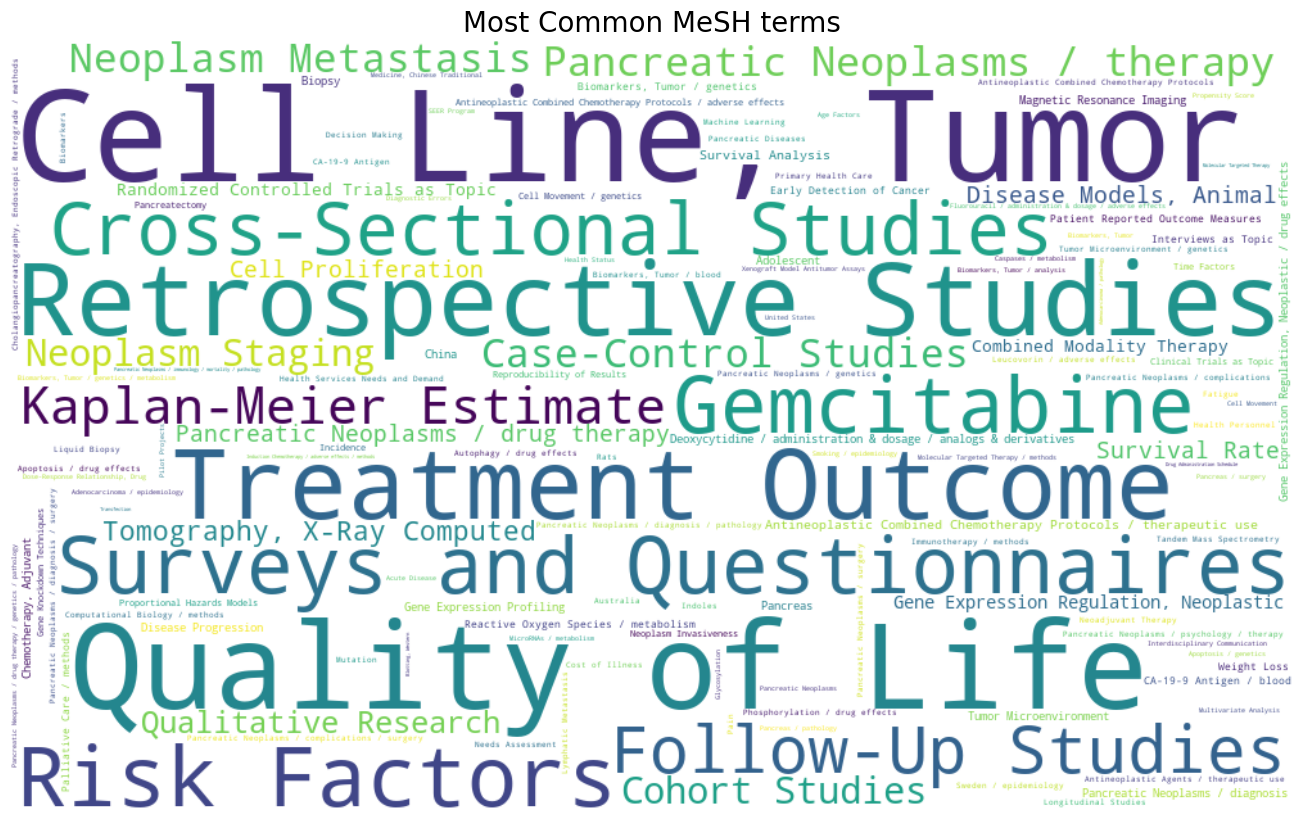

In [85]:
#remove generic terms and plot wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

generic_terms = {'Humans', 'Male', 'Female', 'Aged', 'Middle Aged', 'Adult', 'Prognosis', 'Animals', 'Mice', 'Aged, 80 and over'}

filtered_mesh = {
    k: v for k, v in mesh_counter.items()
    if not any(gen_term in k for gen_term in generic_terms)
}

filtered_mesh_cleaned = {k.replace('*', '').replace('/', ' / '): v for k, v in filtered_mesh.items()
}

wordcloud = WordCloud(width=1000, height=600, background_color='white').generate_from_frequencies(filtered_mesh_cleaned)
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common MeSH terms", fontsize=20)
plt.show()

In [86]:
#count after filtering

from collections import Counter
mesh_counter = Counter(filtered_mesh)
mesh_counter

Counter({'Cell Line, Tumor': 25,
         'Quality of Life': 22,
         'Retrospective Studies': 21,
         'Treatment Outcome': 20,
         'Risk Factors': 15,
         'Surveys and Questionnaires': 13,
         'Gemcitabine': 13,
         'Prospective Studies': 13,
         'Cross-Sectional Studies': 11,
         '*Pancreatic Neoplasms/drug therapy': 10,
         '*Pancreatic Neoplasms/diagnosis': 9,
         'Follow-Up Studies': 9,
         '*Pancreatic Neoplasms/therapy': 8,
         'Kaplan-Meier Estimate': 8,
         'Neoplasm Metastasis': 7,
         'Case-Control Studies': 7,
         'Pancreatic Neoplasms/*therapy': 7,
         'Neoplasm Staging': 6,
         'Gene Expression Regulation, Neoplastic': 6,
         'Cohort Studies': 6,
         '*Quality of Life': 6,
         'Qualitative Research': 6,
         'Tomography, X-Ray Computed': 6,
         '*Pancreatic Neoplasms/pathology': 6,
         'Cell Proliferation': 6,
         'Pancreatic Neoplasms/*drug therapy': 6,
 

### Section Headings

In [ ]:

all_section_headings = []

for file in glob.glob('/data/pmc_xml_files/*.xml'):
    with open(file, encoding="utf-8") as f:
        xml_content = f.read()

    soup = BeautifulSoup(xml_content, features='xml')
    sections = soup.find_all('sec')

    for sec in sections:
        title_tag = sec.find('title')
        if title_tag:
            heading = title_tag.get_text(strip=True)
            if heading:
                all_section_headings.append(heading)

# Get unique section titles
unique_headings = sorted(set(all_section_headings), key=str.lower)
num_unique = len(unique_headings)

print(f"Found {num_unique} unique section headings across all articles:\n")

for heading in unique_headings:
    print("-", heading)

Found 4081 unique section headings across all articles:

- (i) Wound healing assay
- (ii) Transwell migration assay
- 1) Association between dietary intake and changes in nutritional status
- 1) Capecitabine
- 1) Gemcitabine plus 5-FU
- 1) Nutrients intakes
- 1. Background
- 1. Case 1
- 1. Epidemiology
- 1. Fluorouracil
- 1. Introduction
- 1. KRAS
- 1. Pancreatic Cancer and Intercellular Crosstalk
- 1. Pancreatic Cancer Classification
- 1. Patient characteristics
- 1. Patients
- 1. Stromal therapy
- 1. The FOLFIRINOX regimen
- 1.1. Genetic Screening for PDAC
- 1.2. Imaging Modalities for Detection of PDAC
- 1.3. Other Molecular Diagnostic Methods for PDAC Detection
- 1.4. Proteomics-Based Detection of PDAC
- 1.5. Mass Spectrometry- and NMR-Based Metabolic Profiling-Based Detection of PDAC
- 1.6. Advantages and Limitations of NMR-Based Metabolic Profiling
- 10. Conclusions and future perspectives
- 10. Conclusions and Perspectives
- 10. Food Interactions
- 10. Hereditary Cancer Predispo

In [ ]:
import csv

heading_counts = Counter(all_section_headings)
top_n = heading_counts.most_common(100)  # adjust number as needed
top_n

[('Results', 239),
 ('Discussion', 206),
 ('Introduction', 192),
 ('Methods', 158),
 ('Conclusions', 137),
 ('Background', 129),
 ('Conclusion', 115),
 ('1. Introduction', 97),
 ('Statistical analysis', 69),
 ('INTRODUCTION', 48),
 ('3. Results', 40),
 ('5. Conclusions', 40),
 ('4. Discussion', 40),
 ('Funding', 37),
 ('Materials and methods', 36),
 ('Abstract', 34),
 ('CONCLUSION', 33),
 ('Simple Summary', 32),
 ('Supplementary Information', 31),
 ('DISCUSSION', 31),
 ('2. Materials and Methods', 28),
 ('Competing interests', 28),
 ('RESULTS', 27),
 ('Author Contributions', 26),
 ('Supplementary Material', 23),
 ('Availability of data and materials', 23),
 ('Ethics approval and consent to participate', 23),
 ('Materials and Methods', 23),
 ('Author contributions', 22),
 ('Case presentation', 22),
 ('Statistical Analysis', 21),
 ('Study design', 20),
 ('MATERIALS AND METHODS', 18),
 ('Conflict of Interest', 17),
 ('Purpose', 16),
 ('Objective', 15),
 ('Supplementary information', 14),


### TF-IDF with abstract

In [ ]:
import pandas as pd
records = pd.read_csv('/data/pubmed_medline_records.csv')
records_abstract = records["Abstract"]
records_abstract

0      Background: Pancreatic ductal adenocarcinoma (...
1      Pancreatic cancer often presents with vague, n...
2      Chronic pancreatitis (CP) is a progressive con...
3      BACKGROUND: Pancreatic cancer is the twelfth m...
4      BACKGROUND: The Pancreatic Cancer Action Netwo...
                             ...                        
400    BACKGROUND: Pancreatic cancer is a deadly dise...
401    [6]-Gingerol, a major phenolic compound derive...
402    A rare syndrome, sinistral (left-sided) portal...
403    The efficacy and safety of gemcitabine at a st...
404    ERCP is a highly accurate and specific method ...
Name: Abstract, Length: 405, dtype: object

In [1]:
import re
import nltk
import numpy as py
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chery\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chery\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\chery\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
sec_titles = {'background', 'objective', 'methods', 'results', 'conclusion'}
STOPWORDS = set(stopwords.words('english'))

#tokenize abstract sentences
records_abstract_lower = records_abstract.str.lower()
records_abstract_lower

0      background: pancreatic ductal adenocarcinoma (...
1      pancreatic cancer often presents with vague, n...
2      chronic pancreatitis (cp) is a progressive con...
3      background: pancreatic cancer is the twelfth m...
4      background: the pancreatic cancer action netwo...
                             ...                        
400    background: pancreatic cancer is a deadly dise...
401    [6]-gingerol, a major phenolic compound derive...
402    a rare syndrome, sinistral (left-sided) portal...
403    the efficacy and safety of gemcitabine at a st...
404    ercp is a highly accurate and specific method ...
Name: Abstract, Length: 405, dtype: object

In [4]:
#filter out stopwords and generic words, and do lemmatization
lemmatizer = WordNetLemmatizer() #lemmatize words and its inflected forms

clean_abstracts = []

for abstract in records_abstract_lower:
    tokens = word_tokenize(abstract)  #tokenization
    cleaned_token = []

    for word in tokens:
        if word.isalpha():  #remove punctuation and numbers
            if word not in STOPWORDS and word not in sec_titles:
                lemmatized_word = lemmatizer.lemmatize(word)
                cleaned_token.append(lemmatized_word)
    
    clean_abstracts.append(" ".join(cleaned_token))

print(clean_abstracts)

['pancreatic ductal adenocarcinoma pdac typically develops without symptom aggressive progression combined diagnosis underscore critical need improved early detection strategy circulating tumor cell ctc blood potential biomarkers pdac study detection pancreatic ctc evaluated using two diagnostic system comparative approach two distinct nanotheranostic platform developed monoclonal magnetic nanoparticles magnetized exosomes termed magxosomes used monoclonal antibody mesenchymal stem cell msc treated mnps served source magxosomes characterization performed using dynamic light scattering dl inductively coupled plasma mass spectrometry nanoparticle tracking analysis nta transmission electron microscopy tem blood sample collected pancreatic cancer mouse model treated nanotheranostic platform analyzed using homemade magnetic particle spectroscopy mp device detection pancreatic ctc investigated using nanotheranostic platform alongside mp instrument context system demonstrated varying efficien

In [5]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(clean_abstracts)

#convert tf-idf matrix to pandas dataframe
pmc_abstracts_tfidf = pd.DataFrame(tfidf_matrix.toarray(),columns=tfidf_vectorizer.get_feature_names_out())

In [13]:
pmc_abstracts_tfidf.head()

abdomen  abdominal  aberrantly  ability  ablated  ablation  ablative  able  \
0      0.0        0.0         0.0      0.0      0.0       0.0       0.0   0.0   
1      0.0        0.0         0.0      0.0      0.0       0.0       0.0   0.0   
2      0.0        0.0         0.0      0.0      0.0       0.0       0.0   0.0   
3      0.0        0.0         0.0      0.0      0.0       0.0       0.0   0.0   
4      0.0        0.0         0.0      0.0      0.0       0.0       0.0   0.0   

   abnormal  abnormality  ...  youngest  yuande  yueqing  zahn  zealand  zero  \
0       0.0          0.0  ...       0.0     0.0      0.0   0.0      0.0   0.0   
1       0.0          0.0  ...       0.0     0.0      0.0   0.0      0.0   0.0   
2       0.0          0.0  ...       0.0     0.0      0.0   0.0      0.0   0.0   
3       0.0          0.0  ...       0.0     0.0      0.0   0.0      0.0   0.0   
4       0.0          0.0  ...       0.0     0.0      0.0   0.0      0.0   0.0   

   zeta  zheng  zhengs  zinc  
0   0.0    0.0     0.0   0.0  
1   0.0    0.0     0.0   0.0  
2   0.0    0.0     0.0   0.0  
3   0.0    0.0     0.0   0.0  
4   0.0    0.0     0.0   0.0  

[5 rows x 5840 columns]

In [7]:
pmc_abstracts_tfidf.shape


(405, 5840)

In [8]:
#getting mean TF-IDF score per term and rank top 20
mean_tfidf_score = pmc_abstracts_tfidf.mean(axis=0)
top_terms = mean_tfidf_score.sort_values(ascending=False).head(20)
top_terms

pancreatic    0.072237
cancer        0.071573
patient       0.062119
pc            0.037909
tumor         0.031258
treatment     0.029452
cell          0.028908
survival      0.027054
diagnosis     0.026056
symptom       0.025778
early         0.025431
study         0.023892
disease       0.023837
group         0.021437
case          0.019630
clinical      0.019371
rate          0.018635
pdac          0.018459
care          0.018258
therapy       0.018238
dtype: float64

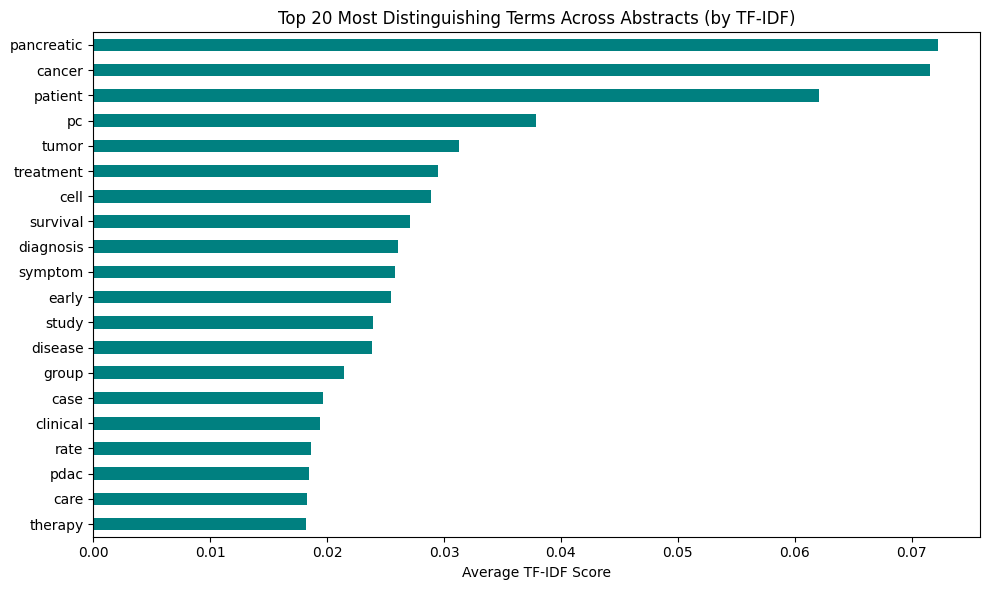

In [10]:
#visualize
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
top_terms.plot(kind='barh', color='teal')
plt.gca().invert_yaxis()
plt.title("Top 20 Most Distinguishing Terms Across Abstracts (by TF-IDF)")
plt.xlabel("Average TF-IDF Score")
plt.tight_layout()
plt.show()

### Clustering

In [14]:
from sklearn.cluster import KMeans

#determine number of clusters using elbow and inertia
inertia = []
for n in range(1, 11):
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(tfidf_matrix)
    inertia.append(kmeans.inertia_)

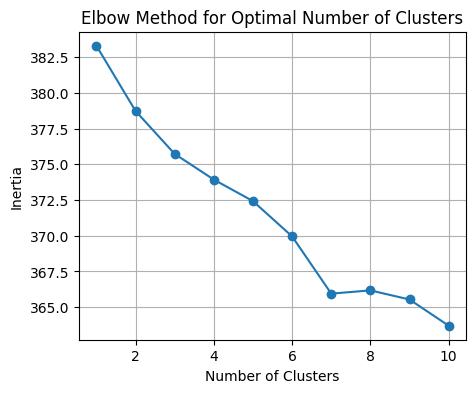

In [16]:
#visualize to find elbow
plt.figure(figsize=(5, 4))
plt.plot(range(1, 11), inertia, marker='o')
plt.title("Elbow Method for Optimal Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

### Experiment with Cluster and PCA

In [30]:
tfidf_matrix

<405x5840 sparse matrix of type '<class 'numpy.float64'>'
	with 36227 stored elements in Compressed Sparse Row format>

#### Try PCA = 50, Cluster = 7

                                              abstract  cluster
0    Background: Pancreatic ductal adenocarcinoma (...        2
1    Pancreatic cancer often presents with vague, n...        1
2    Chronic pancreatitis (CP) is a progressive con...        2
3    BACKGROUND: Pancreatic cancer is the twelfth m...        5
4    BACKGROUND: The Pancreatic Cancer Action Netwo...        5
..                                                 ...      ...
400  BACKGROUND: Pancreatic cancer is a deadly dise...        6
401  [6]-Gingerol, a major phenolic compound derive...        6
402  A rare syndrome, sinistral (left-sided) portal...        1
403  The efficacy and safety of gemcitabine at a st...        5
404  ERCP is a highly accurate and specific method ...        1

[405 rows x 2 columns]


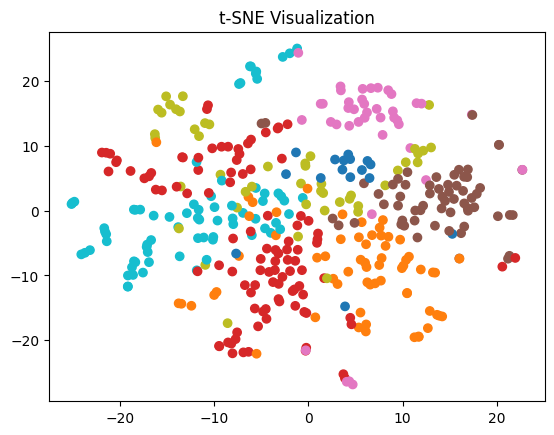

In [67]:
#Clustering abstracts by topic
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# Reduce TF-IDF to 50 dimensions for clustering
pca = PCA(n_components=50, random_state=42)
tfidf_reduced = pca.fit_transform(tfidf_matrix.toarray())

#show clustering based on pca
tfidf_tsne = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(tfidf_reduced)
plt.scatter(tfidf_tsne[:, 0], tfidf_tsne[:, 1], c=kmeans.labels_, cmap='tab10')
plt.title("t-SNE Visualization")

#7 clusters
num_clusters = 7
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(tfidf_reduced)

records_with_clusters = records_abstract.copy()
records_with_clusters = records_with_clusters.to_frame(name='abstract')
records_with_clusters['cluster'] = clusters

print(records_with_clusters)


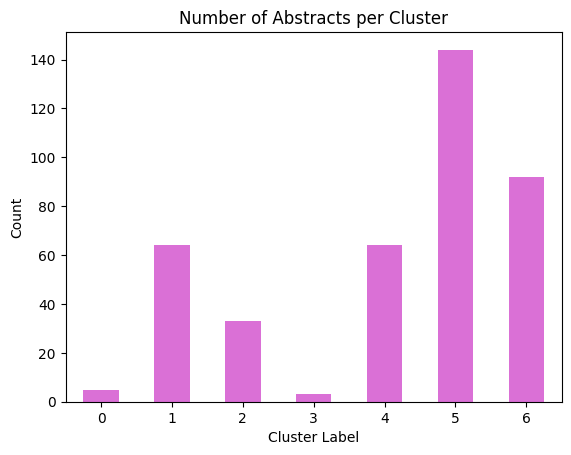

In [68]:
records_with_clusters['cluster'].value_counts().sort_index().plot(kind='bar', color='orchid')
plt.title("Number of Abstracts per Cluster")
plt.xlabel("Cluster Label")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()


In [69]:
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Get the centroid of each cluster in original TF-IDF space
centroids = kmeans.cluster_centers_ @ pca.components_  # project back into TF-IDF space
top_indices = np.argsort(centroids, axis=1)[:, -10:]   # top 10 terms per cluster

terms = tfidf_vectorizer.get_feature_names_out()

for i, indices in enumerate(top_indices):
    print(f"\nCluster {i} top terms:")
    print([terms[idx] for idx in reversed(indices)])

sil_score = silhouette_score(tfidf_reduced, clusters)
print(f"Silhouette Score: {sil_score}")



Cluster 0 top terms:
['pdac', 'ci', 'risk', 'factor', 'nod', 'detection', 'user', 'auc', 'study', 'sensitivity']

Cluster 1 top terms:
['case', 'aip', 'biliary', 'obstruction', 'duodenal', 'stent', 'rare', 'report', 'revealed', 'presentation']

Cluster 2 top terms:
['pdac', 'model', 'mouse', 'ductal', 'cell', 'prediction', 'auc', 'claim', 'adc', 'sensitivity']

Cluster 3 top terms:
['pro', 'qol', 'instrument', 'patient', 'life', 'measure', 'quality', 'management', 'tool', 'eortc']

Cluster 4 top terms:
['cancer', 'pancreatic', 'early', 'diagnosis', 'detection', 'screening', 'factor', 'ai', 'risk', 'stage']

Cluster 5 top terms:
['patient', 'care', 'group', 'pain', 'month', 'survival', 'quality', 'median', 'score', 'life']

Cluster 6 top terms:
['cell', 'pc', 'expression', 'gene', 'tumor', 'resistance', 'mechanism', 'growth', 'effect', 'target']
Silhouette Score: 0.04952475433828353


#### Try PCA = 10, Cluster = 7

Text(0.5, 1.0, 't-SNE Visualization')

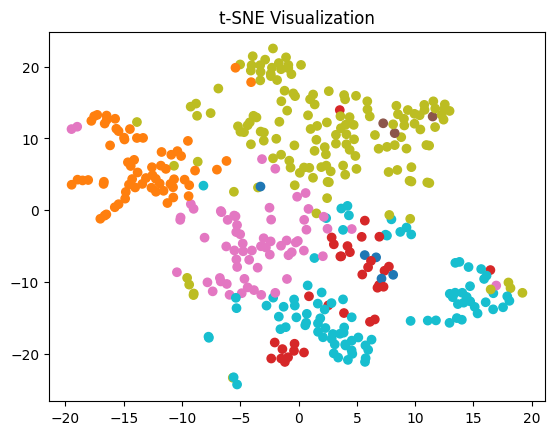

In [70]:
#Clustering abstracts by topic
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# Reduce TF-IDF to 10 dimensions for clustering
pca = PCA(n_components=10, random_state=42)
tfidf_reduced = pca.fit_transform(tfidf_matrix.toarray())

#show clustering based on pca
tfidf_tsne = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(tfidf_reduced)
plt.scatter(tfidf_tsne[:, 0], tfidf_tsne[:, 1], c=kmeans.labels_, cmap='tab10')
plt.title("t-SNE Visualization")



                                              abstract  cluster
0    Background: Pancreatic ductal adenocarcinoma (...        3
1    Pancreatic cancer often presents with vague, n...        2
2    Chronic pancreatitis (CP) is a progressive con...        0
3    BACKGROUND: Pancreatic cancer is the twelfth m...        6
4    BACKGROUND: The Pancreatic Cancer Action Netwo...        6
..                                                 ...      ...
400  BACKGROUND: Pancreatic cancer is a deadly dise...        3
401  [6]-Gingerol, a major phenolic compound derive...        3
402  A rare syndrome, sinistral (left-sided) portal...        2
403  The efficacy and safety of gemcitabine at a st...        2
404  ERCP is a highly accurate and specific method ...        2

[405 rows x 2 columns]


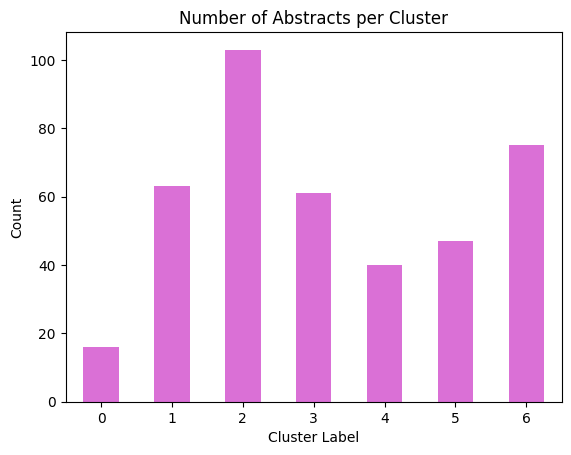

In [71]:
#7 clusters
num_clusters = 7
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(tfidf_reduced)

records_with_clusters = records_abstract.copy()
records_with_clusters = records_with_clusters.to_frame(name='abstract')
records_with_clusters['cluster'] = clusters

print(records_with_clusters)

records_with_clusters['cluster'].value_counts().sort_index().plot(kind='bar', color='orchid')
plt.title("Number of Abstracts per Cluster")
plt.xlabel("Cluster Label")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()


In [72]:

import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Get the centroid of each cluster in original TF-IDF space
centroids = kmeans.cluster_centers_ @ pca.components_  # project back into TF-IDF space
top_indices = np.argsort(centroids, axis=1)[:, -10:]   # top 10 terms per cluster

terms = tfidf_vectorizer.get_feature_names_out()

for i, indices in enumerate(top_indices):
    print(f"\nCluster {i} top terms:")
    print([terms[idx] for idx in reversed(indices)])

sil_score = silhouette_score(tfidf_reduced, clusters)
print(f"Silhouette Score: {sil_score}")



Cluster 0 top terms:
['pdac', 'ductal', 'ci', 'factor', 'risk', 'adenocarcinoma', 'cell', 'model', 'nod', 'cp']

Cluster 1 top terms:
['cancer', 'pancreatic', 'early', 'diagnosis', 'detection', 'screening', 'stage', 'factor', 'review', 'risk']

Cluster 2 top terms:
['case', 'gemcitabine', 'biliary', 'obstruction', 'chemotherapy', 'duodenal', 'aip', 'stent', 'lapc', 'report']

Cluster 3 top terms:
['cell', 'expression', 'growth', 'gene', 'cancer', 'apoptosis', 'effect', 'tumor', 'mouse', 'mechanism']

Cluster 4 top terms:
['pc', 'aip', 'biomarkers', 'mirnas', 'metabolic', 'circulating', 'development', 'early', 'exosomes', 'ctc']

Cluster 5 top terms:
['group', 'survival', 'gene', 'patient', 'model', 'month', 'analysis', 'detection', 'tumor', 'expression']

Cluster 6 top terms:
['care', 'patient', 'need', 'intervention', 'life', 'quality', 'psychological', 'distress', 'nutritional', 'score']
Silhouette Score: 0.19359154109353072


#### Try PCA = 50, Cluster = 5

                                              abstract  cluster
0    Background: Pancreatic ductal adenocarcinoma (...        2
1    Pancreatic cancer often presents with vague, n...        1
2    Chronic pancreatitis (CP) is a progressive con...        4
3    BACKGROUND: Pancreatic cancer is the twelfth m...        3
4    BACKGROUND: The Pancreatic Cancer Action Netwo...        3
..                                                 ...      ...
400  BACKGROUND: Pancreatic cancer is a deadly dise...        2
401  [6]-Gingerol, a major phenolic compound derive...        2
402  A rare syndrome, sinistral (left-sided) portal...        1
403  The efficacy and safety of gemcitabine at a st...        0
404  ERCP is a highly accurate and specific method ...        1

[405 rows x 2 columns]


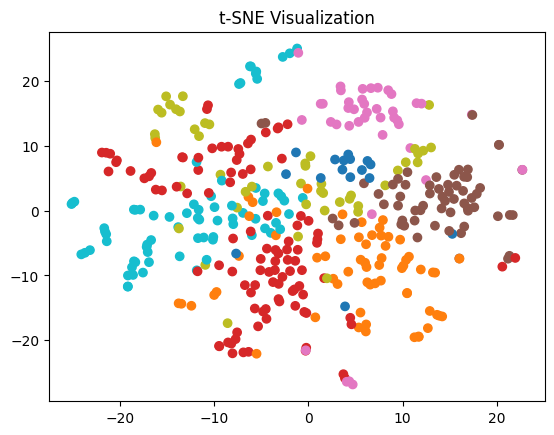

In [73]:
#Clustering abstracts by topic
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# Reduce TF-IDF to 50 dimensions for clustering
pca = PCA(n_components=50, random_state=42)
tfidf_reduced = pca.fit_transform(tfidf_matrix.toarray())

#show clustering based on pca
tfidf_tsne = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(tfidf_reduced)
plt.scatter(tfidf_tsne[:, 0], tfidf_tsne[:, 1], c=kmeans.labels_, cmap='tab10')
plt.title("t-SNE Visualization")

#5 clusters
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(tfidf_reduced)

records_with_clusters = records_abstract.copy()
records_with_clusters = records_with_clusters.to_frame(name='abstract')
records_with_clusters['cluster'] = clusters

print(records_with_clusters)

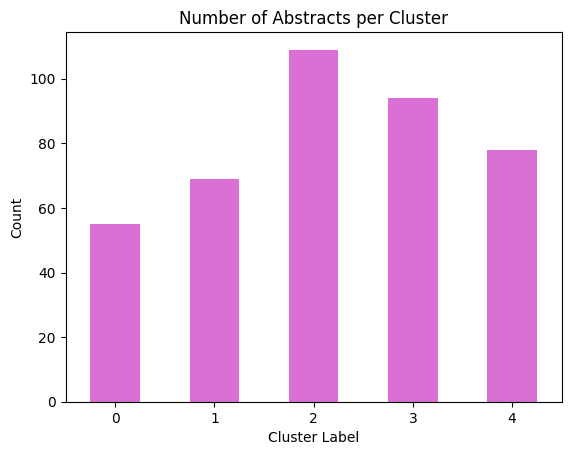

In [74]:
records_with_clusters['cluster'].value_counts().sort_index().plot(kind='bar', color='orchid')
plt.title("Number of Abstracts per Cluster")
plt.xlabel("Cluster Label")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()


In [75]:
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Get the centroid of each cluster in original TF-IDF space
centroids = kmeans.cluster_centers_ @ pca.components_  # project back into TF-IDF space
top_indices = np.argsort(centroids, axis=1)[:, -10:]   # top 10 terms per cluster

terms = tfidf_vectorizer.get_feature_names_out()

for i, indices in enumerate(top_indices):
    print(f"\nCluster {i} top terms:")
    print([terms[idx] for idx in reversed(indices)])

sil_score = silhouette_score(tfidf_reduced, clusters)
print(f"Silhouette Score: {sil_score}")


Cluster 0 top terms:
['group', 'ci', 'survival', 'patient', 'median', 'gemcitabine', 'month', 'day', 'chemotherapy', 'sbrt']

Cluster 1 top terms:
['case', 'aip', 'biliary', 'obstruction', 'duodenal', 'stent', 'rare', 'report', 'revealed', 'presentation']

Cluster 2 top terms:
['cell', 'pc', 'expression', 'gene', 'growth', 'tumor', 'target', 'resistance', 'protein', 'mouse']

Cluster 3 top terms:
['care', 'patient', 'pain', 'score', 'quality', 'life', 'nutritional', 'pert', 'qol', 'psychological']

Cluster 4 top terms:
['cancer', 'early', 'pancreatic', 'detection', 'diagnosis', 'factor', 'screening', 'stage', 'risk', 'ai']
Silhouette Score: 0.05580606800726418


#### Try PCA = 10, Cluster = 5

Text(0.5, 1.0, 't-SNE Visualization')

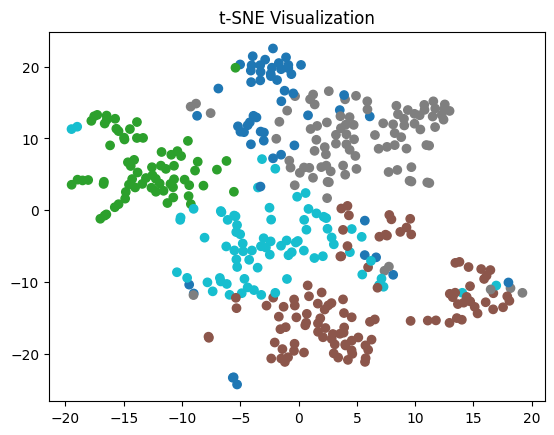

In [ ]:
#Clustering abstracts by topic
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# Reduce TF-IDF to 10 dimensions for clustering
pca = PCA(n_components=10, random_state=42)
tfidf_reduced = pca.fit_transform(tfidf_matrix.toarray())

#show clustering based on pca
tfidf_tsne = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(tfidf_reduced)
plt.scatter(tfidf_tsne[:, 0], tfidf_tsne[:, 1], c=kmeans.labels_, cmap='tab10')
plt.title("t-SNE Visualization")


                                              abstract  cluster
0    Background: Pancreatic ductal adenocarcinoma (...        3
1    Pancreatic cancer often presents with vague, n...        1
2    Chronic pancreatitis (CP) is a progressive con...        0
3    BACKGROUND: Pancreatic cancer is the twelfth m...        1
4    BACKGROUND: The Pancreatic Cancer Action Netwo...        2
..                                                 ...      ...
400  BACKGROUND: Pancreatic cancer is a deadly dise...        3
401  [6]-Gingerol, a major phenolic compound derive...        3
402  A rare syndrome, sinistral (left-sided) portal...        2
403  The efficacy and safety of gemcitabine at a st...        2
404  ERCP is a highly accurate and specific method ...        2

[405 rows x 2 columns]


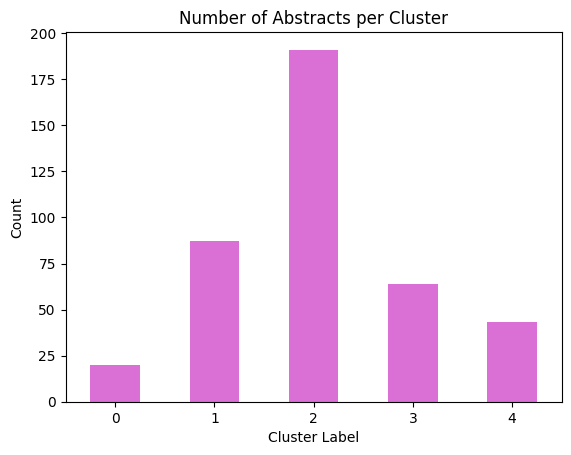

In [77]:
#5 clusters
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(tfidf_reduced)

records_with_clusters = records_abstract.copy()
records_with_clusters = records_with_clusters.to_frame(name='abstract')
records_with_clusters['cluster'] = clusters

print(records_with_clusters)
records_with_clusters['cluster'].value_counts().sort_index().plot(kind='bar', color='orchid')
plt.title("Number of Abstracts per Cluster")
plt.xlabel("Cluster Label")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

In [78]:
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Get the centroid of each cluster in original TF-IDF space
centroids = kmeans.cluster_centers_ @ pca.components_  # project back into TF-IDF space
top_indices = np.argsort(centroids, axis=1)[:, -10:]   # top 10 terms per cluster

terms = tfidf_vectorizer.get_feature_names_out()

for i, indices in enumerate(top_indices):
    print(f"\nCluster {i} top terms:")
    print([terms[idx] for idx in reversed(indices)])

sil_score = silhouette_score(tfidf_reduced, clusters)
print(f"Silhouette Score: {sil_score}")


Cluster 0 top terms:
['pdac', 'ci', 'ductal', 'risk', 'model', 'factor', 'adenocarcinoma', 'nod', 'cp', 'biomarkers']

Cluster 1 top terms:
['cancer', 'pancreatic', 'early', 'diagnosis', 'detection', 'screening', 'stage', 'factor', 'risk', 'diagnostic']

Cluster 2 top terms:
['patient', 'care', 'pain', 'month', 'life', 'quality', 'palliative', 'chemotherapy', 'day', 'group']

Cluster 3 top terms:
['cell', 'expression', 'gene', 'growth', 'apoptosis', 'effect', 'cancer', 'mouse', 'tumor', 'assay']

Cluster 4 top terms:
['pc', 'aip', 'biomarkers', 'mirnas', 'metabolic', 'circulating', 'development', 'exosomes', 'early', 'ctc']
Silhouette Score: 0.1667387246855924
